In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline

/Users/ryanbarouki/miniconda3/envs/pytorchenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
def build_dataset(words, block_size=3):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = jnp.array(X)
    Y = jnp.array(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

In [5]:
key = jax.random.PRNGKey(420+69)
# Split the data train/val/test at the word level
import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

(182588, 3) int32 (182588,) int32
(22782, 3) int32 (22782,) int32
(22776, 3) int32 (22776,) int32


In [ ]:
# TODO
# - become a backprop ninja: Part 4 (split out to new notebook)

emb_dim = 10
context_size = 3
hidden_size = 200
vocab_size = 27

C = jax.random.normal(key, (vocab_size,emb_dim))
W1 = jax.random.normal(key, (context_size*emb_dim,hidden_size)) * (5/3)/((emb_dim*context_size)**0.5)
b1 = jax.random.normal(key, hidden_size) * 0.01
W2 = jax.random.normal(key, (hidden_size, vocab_size)) * 0.01
b2 = jax.random.normal(key, vocab_size) * 0
bngain = jnp.ones((1,hidden_size))
bnbias = jnp.zeros((1,hidden_size))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

In [7]:
print(f"Number of parameters: {sum([p.size for p in parameters])}")

Number of parameters: 12297


In [8]:
from collections import namedtuple

TrainState = namedtuple('TrainState', 'params bn_ra_mean bn_ra_std')

# def __init__(self):
#     self.running_mean = jnp.zeros((1, self.hidden_size))
#     self.running_std = jnp.ones((1, self.hidden_size))

def model(params, X, bn_ra_mean, bn_ra_std, bn_momentum=0.001, training=True):
    C, W1, b1, W2, b2, bngain, bnbias = params
    emb = C[X]
    hpreact = emb.reshape(-1,emb_dim*context_size) @ W1 + b1
    if training:
        mean = hpreact.mean(axis=0, keepdims=True)
        std = hpreact.std(axis=0,keepdims=True)
        hpreact = bngain * ((hpreact - mean)/std) + bnbias
        new_mean = (1 - bn_momentum) * bn_ra_mean + bn_momentum * mean
        new_std = (1 - bn_momentum) * bn_ra_std + bn_momentum * std
    else:
        # Use running average of mean and std
        hpreact = bngain * ((hpreact - bn_ra_mean)/bn_ra_std) + bnbias
        new_mean = bn_ra_mean
        new_std = bn_ra_std

    h = jnp.tanh(hpreact)
    logits = h @ W2 + b2
    return logits, (new_mean, new_std)

def loss_fn(params, bnstate, X, Y):
    mean, std = bnstate
    logits, bnstats = model(params, X, mean, std)
    return optax.losses.softmax_cross_entropy_with_integer_labels(logits, Y).mean(), bnstats


@jax.jit
def train_step(params, bnstate, X_batch, Y_batch, lr):
    (loss, bnstats), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, bnstate, X_batch, Y_batch)

    # Gradients and gradient descent
    new_params = [p - lr * g for p, g in zip(params, grads)]
    return loss, new_params, bnstats

In [9]:
lossi = []
stepi = []

In [11]:

# USED TO DETERMINE GOOD LEARNING RATE
# lri = []
# lre = jnp.linspace(-3,0,1000)
#lr = 10**lre
# =====================================

# Training loop
batch_size = 32

bnstats = (jnp.zeros((1, hidden_size)), jnp.ones((1, hidden_size)))
params = parameters
for i in tqdm(range(200000)):
    lr = 0.1 if i < 100000 else 0.01
    # mini-batch
    key, subkey = jax.random.split(key)
    ix = jax.random.randint(subkey, (batch_size), 0, Xtr.shape[0])

    loss, params, bnstats = train_step(params, bnstats, Xtr[ix], Ytr[ix], lr)

    # Track stats to determine good learning rate
    # lri.append(lr[i])
    lossi.append(jnp.log10(loss))
    stepi.append(i)

print(loss)

100%|██████████| 200000/200000 [01:12<00:00, 2745.29it/s]

1.9974155


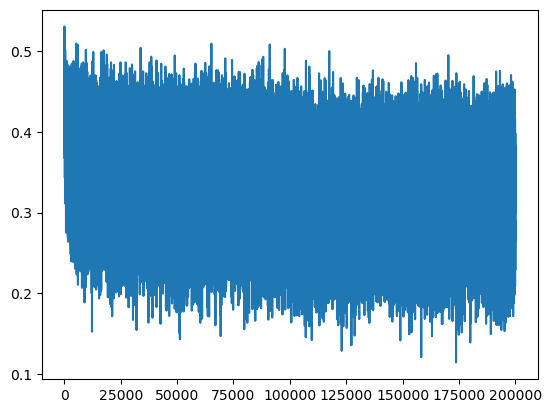

In [12]:
plt.plot(stepi, lossi)

In [14]:
#plt.plot(lri, lossi)
loss, _= loss_fn(params, bnstats, Xdev, Ydev)
print(loss)

2.1126947


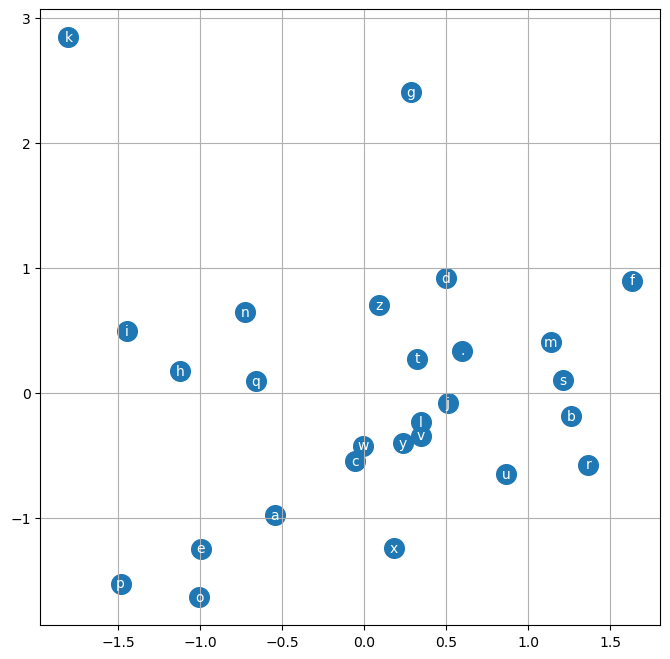

In [ ]:
# Only really made sense when we were using 2-dim embedding matrix C
plt.figure(figsize=(8,8))
plt.scatter(C[:,0], C[:,1], s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0], C[i,1], itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [15]:
logits, _= model(params, Xdev[:1], bnstats[0], bnstats[1], training=False)
logits

Array([[-4.6093946 ,  1.7917719 ,  0.6763427 ,  1.1666722 ,  1.0253906 ,
         0.80501163, -0.4007216 ,  0.08370864,  0.19114582, -0.37692606,
         1.3799764 ,  1.7288439 ,  0.86737007,  1.3304696 ,  0.4988303 ,
        -0.5394652 , -0.37819916, -1.9892464 ,  0.73890674,  1.1982256 ,
         0.7226164 , -2.2862546 , -0.64054585, -0.9970407 , -1.8557564 ,
        -0.26272386,  0.36953866]], dtype=float32)

In [17]:
# Sample from the trained model

sample_key = jax.random.PRNGKey(4206969)

for _ in range(20):
    out = []
    context = [0] * 3

    while True:
        sample_key, sample_sub_key = jax.random.split(sample_key)
        logits, _ = model(params, jnp.array([context]), bnstats[0], bnstats[1], training=False)
        ix = jax.random.categorical(sample_sub_key, logits)[0]
        context = context[1:] + [ix]
        out.append(int(ix))
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))


kennoh.
azvi.
abrianeliodtynn.
sylia.
jomiennys.
lorela.
tedianni.
coobvabella.
kolee.
elkowtannis.
sta.
nathelgs.
alee.
hamryn.
aya.
zyela.
niliana.
ayrin.
mica.
ston.
